In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [5]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [6]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 One-hot 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [7]:
class TwoLayerNet:
    """
      A two-layer fully-connected neural network. The net has an input dimension of
      N, a hidden layer dimension of H, and performs classification over C classes.
    """

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        가중치 초기화
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        #파라미터 설정
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        #2개의 층
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    #여기에서 차이점이 있음(단층과 비교해보기)   
    def gradient(self, x, t): 
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward 예측값- 정답 = 에러
        dy = (y - t) / batch_num #error, loss를 구하는 식
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        #여기부분이 많이 반복된다
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)
        #변화시킬 수 있는 것 W, -> 구조를 잘 알아두기
        return grads

In [8]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [9]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

* 형상 출력해보기

In [10]:
x_train.shape, t_train.shape

((60000, 784), (60000, 10))

### test 함수

In [11]:
def test_num(idx):
    x1 = x_test[idx]
    t1 = t_test[idx]
    title = '#{} {}'.format(np.argmax(t1), t1)
    img = x1.reshape((28,28))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()
    y1 = network.predict(x1)
    for i in range(10):
        print('#{}\t{}\t{:.3f}'.format(i, t1[i], y1[i]))

학습 전에 테스트 해보기

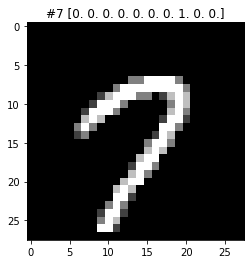

#0	0.0	0.096
#1	0.0	0.104
#2	0.0	0.098
#3	0.0	0.097
#4	0.0	0.098
#5	0.0	0.102
#6	0.0	0.101
#7	1.0	0.106
#8	0.0	0.097
#9	0.0	0.103


In [12]:
test_num(3423)

확률이 이상하게 나옴

### 학습하기
* Hyperparameters

In [13]:
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

In [14]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

* Train the network!

In [15]:
# 1에폭당 반복 수
iter_per_epoch = max(train_size // batch_size, 1)
print('iter_per_epoch = {}//{}={}'.format(train_size, batch_size,iter_per_epoch))

iter_per_epoch = 60000//100=600


In [16]:
print('epoch\tloss\tacc_trn\tacc_test')
print('---------------------------------')
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask] #x
    t_batch = t_train[batch_mask] #정답
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신(중요**업데이트하는 법)
    #기울기에 따라 업데이트하기
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록(loss가 어떻게 되는지 보기위함)
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print('{}\t{:.3f}\t{:.3f}\t{:.3f}'.format(i//iter_per_epoch, loss, train_acc, test_acc))

epoch	loss	acc_trn	acc_test
---------------------------------
0	2.293	0.120	0.117
1	0.917	0.791	0.797
2	0.503	0.876	0.881
3	0.566	0.898	0.901
4	0.262	0.909	0.910
5	0.281	0.915	0.918
6	0.434	0.920	0.921
7	0.273	0.925	0.926
8	0.223	0.929	0.930
9	0.239	0.932	0.935
10	0.290	0.935	0.936
11	0.290	0.938	0.938
12	0.254	0.940	0.939
13	0.253	0.943	0.942
14	0.188	0.944	0.944
15	0.239	0.947	0.945
16	0.204	0.948	0.947


### 결과 그려보기 및 분석

Text(0, 0.5, 'loss')

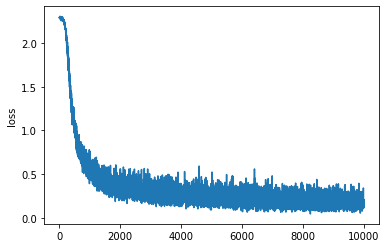

In [17]:
plt.plot(train_loss_list)
plt.ylabel('loss')

loss가 줄어드는 것을 볼 수 있음

* Train accuracy

In [18]:
train_acc = network.accuracy(x_train, t_train)
print(train_acc)

0.9488833333333333


* Test accuracy

In [19]:
test_acc = network.accuracy(x_test, t_test)
print(test_acc)

0.9482


* 하나만 테스트해보기 : 그림 그리는 과정은 03_NeuralNetwork/01_3_NN_MNIST_Exploration.ipynb 을 참고

In [20]:
idx_to_test = 3423#0~9999중 한 개 바꾸어서 해보세요
x1 = x_test[idx_to_test]
t1 = t_test[idx_to_test]

In [21]:
x1.shape

(784,)

In [22]:
t1.shape

(10,)

In [23]:
title = '#{} {}'.format(np.argmax(t1), t1)
print(title)

#7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [24]:
img = x1.reshape((28,28))

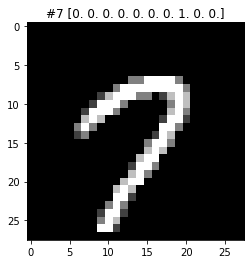

In [25]:
#plt.plot(img)
plt.imshow(img, cmap='gray')
plt.title(title)
plt.show()

In [26]:
y1 = network.predict(x1)

In [27]:
print(y1)

[0.     0.     0.     0.     0.     0.0001 0.     0.9565 0.     0.0433]


In [28]:
print(t1) # 정답
print(y1) # 학습된 neural network 가 구한 값.

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.     0.     0.     0.     0.     0.0001 0.     0.9565 0.     0.0433]


In [29]:
for i in range(10):
    print('#{}\t{}\t{:.3f}'.format(i, t1[i], y1[i]))

#0	0.0	0.000
#1	0.0	0.000
#2	0.0	0.000
#3	0.0	0.000
#4	0.0	0.000
#5	0.0	0.000
#6	0.0	0.000
#7	1.0	0.956
#8	0.0	0.000
#9	0.0	0.043


클래스 정답 예측

**TODO**  
* idx_to_test 를 바꾸어 가며 테스트해보고 결과값 논의해보기(최소3개이상)    
    예를들면 네트워크가 약간이라도 확률을 만들어내는 숫자 분석을 해볼수 있음. 
    : 7과 1이 비슷하기에 정답은 7이지만 1에도 약간의 확률값이 생겼다.(551 틀림)
* Training 이 되기 전에는 어떻게 예측을 하는지 해보기 y1 = network.predict(x1)  
  


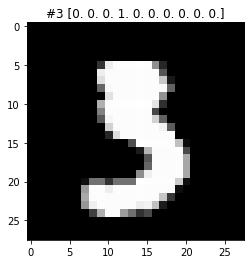

#0	0.0	0.000
#1	0.0	0.001
#2	0.0	0.000
#3	1.0	0.838
#4	0.0	0.000
#5	0.0	0.154
#6	0.0	0.000
#7	0.0	0.000
#8	0.0	0.006
#9	0.0	0.001


In [30]:
test_num(450)

이 데이터의 경우 3 윗부분이 잘 그려지지 않았음에도 잘 분류를 했다. 3이지만 5처럼 보이기도 하다. 높은 확률은 아니지만 5에도 확률이 조금 있는 것을 볼 수 있다.

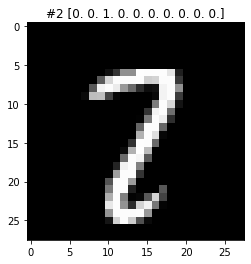

#0	0.0	0.000
#1	0.0	0.006
#2	1.0	0.062
#3	0.0	0.084
#4	0.0	0.000
#5	0.0	0.001
#6	0.0	0.000
#7	0.0	0.834
#8	0.0	0.009
#9	0.0	0.004


In [31]:
test_num(321)

정답은 2이지만 예측은 7로 되었다.  
2의 아래부분이 짧아서 육안으로 보기에도 7이랑 비슷해보인다.  
7다음으로는 3과 2가 높은 확률로 나왔다.

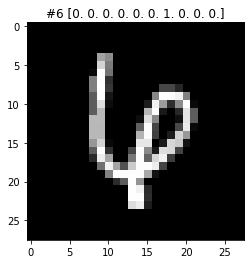

#0	0.0	0.000
#1	0.0	0.001
#2	0.0	0.055
#3	0.0	0.001
#4	0.0	0.569
#5	0.0	0.003
#6	1.0	0.037
#7	0.0	0.306
#8	0.0	0.016
#9	0.0	0.014


In [32]:
test_num(2422)

정답은 6이지만 4가 가장 높은 확률로 나옴  
6이 너무 누워 있어서 선이 이어진 4로 보인다. 4다음으로 높은 것은 7. 이유를 모르겠다..

**References**  
* Stanford CS231n, Two-layer network  
https://cs231n.github.io/ https://github.com/yunjey/cs231n/blob/master/assignment1/cs231n/classifiers/neural_net.py
  
* 주교재  
https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch04/train_neuralnet.py